In [61]:
!pip install ensemble_boxes

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/conda/envs/detection/lib/python3.7/site-packages/numpy-1.20.3.dist-info/METADATA'



In [62]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO
import json
import random
import pandas as pd

import cv2
import matplotlib.pyplot as plt

In [63]:
submission_files = ['./work_dirs/swinadamw20cas_aug_trash/submission_best_bbox_mAP_epoch_19.csv'] # submission lists
submission_df = [pd.read_csv(file) for file in submission_files]

In [64]:
image_ids = submission_df[0]['image_id'].tolist()

In [65]:
annotation = '../dataset/test.json'
coco = COCO(annotation)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [66]:
prediction_strings = []
file_names = []
iou_thr = 0.4

for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
    if len(boxes_list):
        boxes, scores, labels = nms(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(label) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

In [67]:
import os
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('submission_ensemble4.csv')

submission.head()

,PredictionString,image_id
0,0 0.14498089 480.22156 592.801 585.4872 657.43...,test/0000.jpg
1,0 0.3565709 638.9922 643.7827 684.97687 836.75...,test/0001.jpg
2,0 0.5237082 880.7029 467.09613 1021.77155 636....,test/0002.jpg
3,9 0.9898181 155.16644 263.43185 910.22876 812....,test/0003.jpg
4,0 0.3887472 427.04092 414.45663 655.6471 567.8...,test/0004.jpg


In [68]:
#submission = pd.read_csv('./work_dirs/swinadamw20casTTAmosaic_trash/swinadamw20casTTAmosaic_trash.csv')

In [69]:
def get_file_path(json_file, image_num):
    file_path = json_file['images'][image_num]['file_name']
    return file_path


def get_annotations(json_file, image_num):
    anns = [ann for ann in json_file['annotations'] if ann['image_id'] == image_num]
    return anns


def read_image(dataset_path, file_path):
    image = cv2.imread(dataset_path + file_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def plot_bbox(image, anns):
    for ann in anns:
        xmin, ymin, w, h = map(int, ann['bbox'])
        image = cv2.rectangle(image, (xmin, ymin), (xmin + w, ymin + h), (0, 0, 255), 3)
    plt.imshow(image)

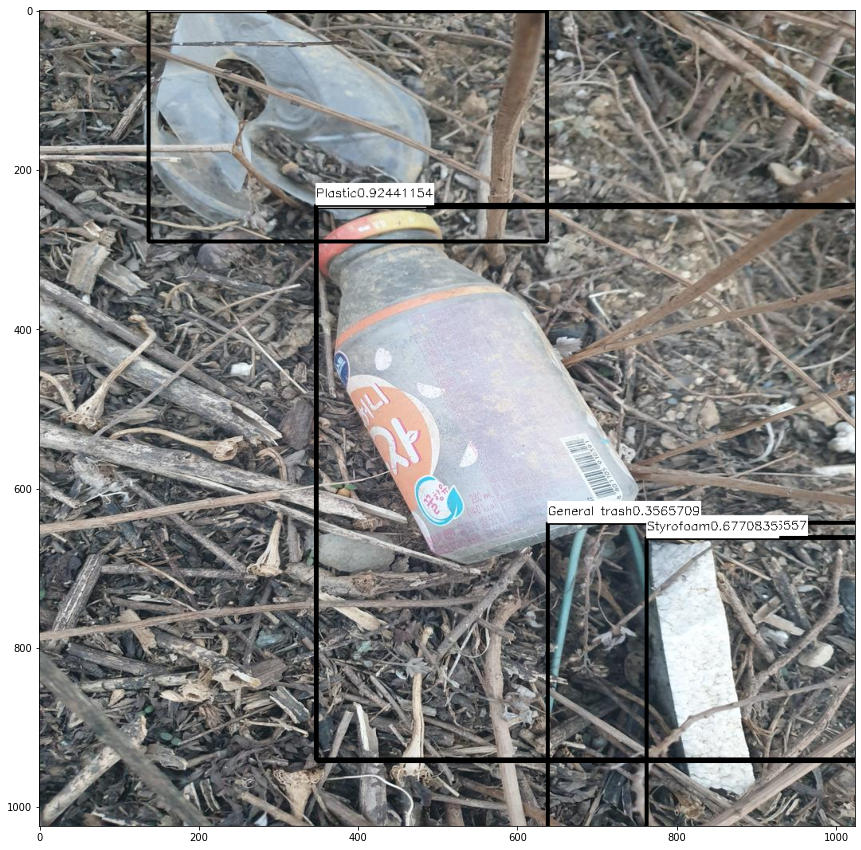

In [70]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")


import math
plt.figure(figsize=(15,15))
bbox_inform = []
idx = 1
for i in range(len(submission)):
    if len(submission['PredictionString'].iloc[i].split(' ')[:-1]) % 6 == 0:
        dummy = [list(map(float, submission['PredictionString'].iloc[i].split(' ')[:-1])), submission['image_id'].iloc[i]]
        bbox_inform.append(dummy)
    # 바운딩 박스 사각형 그리기\
dataset_path = '../dataset/'
img = read_image(dataset_path, bbox_inform[idx][1])
for i in range(int(len(bbox_inform[idx][0]) / 6)):
    c, score, xmin, ymin, w, h = bbox_inform[idx][0][i * 6 : i * 6 + 6]
    c, xmin, ymin, w, h =int(c), int(xmin), int(ymin), int(w), int(h)
    if score > 0.1:
        img = cv2.rectangle(img, (xmin, ymin), (xmin + w, ymin + h), (0, 0, 0), 3)
        # 클래스 글자 넣기
        text_size, _ = cv2.getTextSize(str(classes[c]) + str(score), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        text_w, text_h = text_size
        if xmin - text_h < 1:
            cv2.rectangle(img, (xmin, ymin), (xmin + text_w, ymin + 15 + text_h), [255,255,255], -1)
            img = cv2.putText(img, str(classes[c]) + str(score), (xmin, ymin + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        else:
            cv2.rectangle(img, (xmin, ymin - 15 - text_h), (xmin + text_w, ymin), [255,255,255], -1)
            img = cv2.putText(img, str(classes[c]) + str(score), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
plt.imshow(img)